In [47]:
import os
from typing import List
from pprint import pprint
from string import ascii_letters, digits

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [48]:
token_start = "[START]"
token_end = "[END]"
token_unknown = "[UNK]"
special_tokens = [token_start, token_end, token_unknown]

CNN_WINDOW_SIZE = 50

In [49]:
with open(os.path.join('dataset', "Vingt_mille_lieues_sous_les_mers_Texte_entier.txt"), "r", encoding="utf-8") as file:
    raw_text = file.read()
print(raw_text[:300])

L’année 1866 fut marquée par un événement bizarre, un phénomène inexpliqué et inexplicable que personne n’a sans doute oublié. Sans parler des rumeurs qui agitaient les populations des ports et surexcitaient l’esprit public à l’intérieur des continents, les gens de mer furent particulièrement émus. 


In [50]:
vocabulary = set(raw_text) | set(ascii_letters+digits) | set(special_tokens)
"  ".join(vocabulary)

"è  d  v  q  F  O  ï  K  â  N  2  H  ù  V  z  I  u  5  !  Q  4  r  [  ,  T  w  :  ;  Œ  À  Ç  -  L  j  Z  0  «  i  É     U  [END]  6  S  [START]  ç  9  Ê  M  l  ↑  k  °  E  \n  a  û  8  7  Y  J  R  ′  ]  m  Ô  P  C  ’  D  é  b  »  È  [UNK]  x  s  n  t  (  h  f  e  *  y  3  p  .  ë  —  B  1  Æ  W  )  '  ?  à  G  …  ô  œ  X  î  c  g  A  ê  ü  o"

In [51]:
_id_to_token = list(vocabulary)
_token_to_id = {k:i for i,k in enumerate(_id_to_token)}
vocab_size = len(_id_to_token)

In [52]:
def tokens_to_text(token_ids: List[int]) -> str:
    """convert a list of tokens to a text."""
    return "".join(_id_to_token[i] for i in token_ids)

def text_to_tokens(text: str) -> List[int]:
    """convert a list of tokens to a text."""
    for special_token in special_tokens:
        text = text.replace(special_token, "")
    return [_token_to_id.get(i, _token_to_id[token_unknown]) for i in text]

In [53]:
text = "Hello, my name is Marco"
print(text)
tokens = text_to_tokens('Hello, my name is Marco')
print(tokens)
new_text = tokens_to_text(tokens)
print(new_text)
assert new_text == text

Hello, my name is Marco
[11, 82, 49, 49, 109, 23, 39, 64, 84, 39, 77, 55, 64, 82, 39, 37, 76, 39, 48, 55, 21, 104, 109]
Hello, my name is Marco


In [54]:
# Dataset for CCNs with a view window
x_values, y_values = [], []
for i in tqdm(range(CNN_WINDOW_SIZE, len(raw_text))):
    x = text_to_tokens(raw_text[i-CNN_WINDOW_SIZE:i])
    y = text_to_tokens(raw_text[i])[0]
    x_values.append(x)
    y_values.append(y)
x_values = np.array(x_values, dtype=np.int8)
y_values = np.array(y_values, dtype=np.int8)

100%|██████████| 1756489/1756489 [00:22<00:00, 77965.26it/s] 


In [55]:
# Split train and test
train_size = int(x_values.shape[0] *0.8)
x_train, x_test = x_values[:train_size], x_values[train_size:]
y_train, y_test = y_values[:train_size], y_values[train_size:]
del x_values, y_values
print(f"Train size {x_train.shape[0]}, test size {x_test.shape[0]}")

Train size 1405191, test size 351298


In [56]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(CNN_WINDOW_SIZE,)),
    keras.layers.Embedding(input_dim=vocab_size, output_dim=10),
    keras.layers.Flatten(),
    keras.layers.Dense(30),
    keras.layers.ReLU(),
    keras.layers.Dense(vocab_size),
    keras.layers.Softmax()
])

In [66]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(CNN_WINDOW_SIZE,)),
    keras.layers.Embedding(input_dim=vocab_size, output_dim=10),
    keras.layers.Conv1D(10, kernel_size=3, padding="same"),
    keras.layers.Conv1D(40, kernel_size=3, padding="same"),
    keras.layers.ReLU(),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(60, kernel_size=3, padding="same"),
    keras.layers.Conv1D(100, kernel_size=3, padding="same"),
    keras.layers.ReLU(),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(200),
    keras.layers.Dense(vocab_size),
    keras.layers.Softmax()
])

In [67]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.sparse_categorical_crossentropy
)

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 10)            1100      
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 10)            310       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 40)            1240      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 50, 40)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 40)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 60)            7260      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 100)          

In [73]:
history = model.fit(x=x_train, y=y_train, batch_size=4096, epochs=50, validation_data=(x_test, y_test), callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/50
344/344 [==============================] - 15s 42ms/step - loss: 1.4225 - val_loss: 1.4647
Epoch 2/50
344/344 [==============================] - 15s 43ms/step - loss: 1.4210 - val_loss: 1.4690
Epoch 3/50
344/344 [==============================] - 15s 43ms/step - loss: 1.4199 - val_loss: 1.4633
Epoch 4/50
344/344 [==============================] - 15s 43ms/step - loss: 1.4181 - val_loss: 1.4707
Epoch 5/50
344/344 [==============================] - 15s 43ms/step - loss: 1.4174 - val_loss: 1.4579
Epoch 6/50
344/344 [==============================] - 15s 43ms/step - loss: 1.4157 - val_loss: 1.4666
Epoch 7/50
344/344 [==============================] - 15s 43ms/step - loss: 1.4145 - val_loss: 1.4638
Epoch 8/50
344/344 [==============================] - 15s 43ms/step - loss: 1.4139 - val_loss: 1.4619
Epoch 9/50
344/344 [==============================] - 15s 43ms/step - loss: 1.4115 - val_loss: 1.4649
Epoch 10/50
344/344 [==============================] - 15s 43ms/step - loss: 1.410

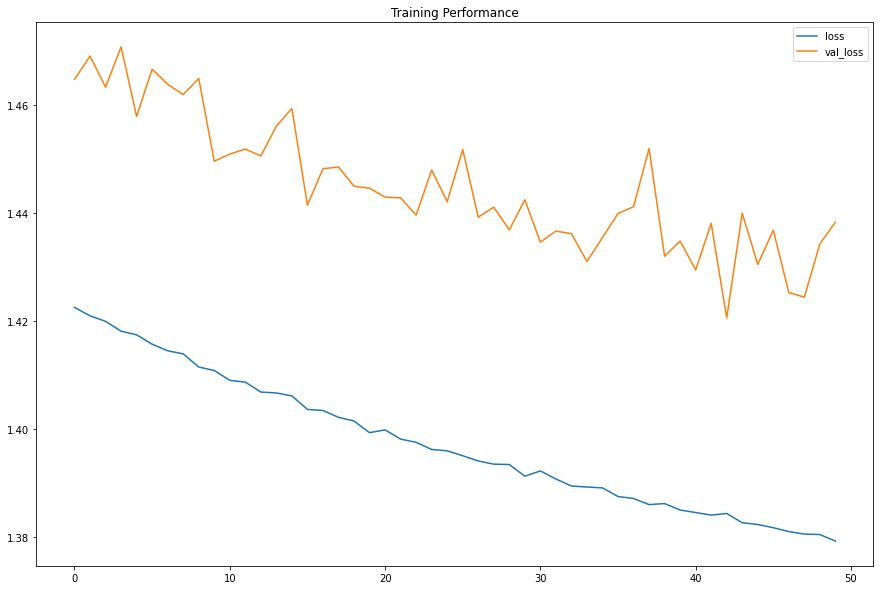

In [74]:
pd.DataFrame(history.history).plot.line(title="Training Performance", figsize=(15,10));

In [77]:
max_length = 300
beginning_sentence = "Capitaine Nemo prit la parole, sa canne à la main, et s'addressa à "
assert len(beginning_sentence) >= CNN_WINDOW_SIZE 

In [78]:
token_ids = text_to_tokens(beginning_sentence)
while len(token_ids) < max_length:
    next_token = model(
        np.array([token_ids[-CNN_WINDOW_SIZE:]], dtype=np.int8)
    )
    token_ids.append(np.argmax(next_token))
print(tokens_to_text(token_ids))

Capitaine Nemo prit la parole, sa canne à la main, et s'addressa à l’honner de cette chambre profondeur de la mer de cette par les plus de la planent de cette par les plus de la faire de l’Une des flots de ces parties de Hord de l’Helettait des plans sont des plans son seulement de la mer. On de cet
